<a href="https://colab.research.google.com/github/DesiPilla/demographics-voterid-turnout/blob/master/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install geopandas
import geopandas as gp

from statsmodels.stats.weightstats import ztest
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 14.7MB 306kB/s 
     |████████████████████████████████| 10.4MB 39.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Datasets

In [0]:
# Load full datasets (only one nan row)
data = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data.shp').dropna()
data_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_mainland.shp').dropna()
data_no_ak = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_no_ak.shp').dropna()

In [0]:
# Load demographic datasets
demgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo.shp')
demgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo_mainland.shp')

# Load voter ID datasets
votgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo.shp')
votgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo_mainland.shp')

# Load turnout datasets
turngeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo.shp')
turngeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo_mainland.shp')

# Non-Machine Learning Analysis

## Classify "disadvantaged" counties

We will weight certain features to classify counties as either “disadvantaged” or “non-disadvantaged”.

The four features being used to create this "disadvantage index" are the following:
 * `1 - MedieanHous`: the smaller the median househole income, the more disadvantaged the county is.
 * `1 - CollegeDeg`: the smaller the percentage of residents with a college degree, the more disadvantaged the county is.
 * `MedianAge`: the larger the median age, the more disadvantaged the county is.
 * `not_white`: the larger the minority population, the more disadvantaged the county is.

In [5]:
cols = ['MedianHous', 'CollegeDeg', 'MedianAge', 'not_white']

# Get county fips and geometry for future use
county_fip = data_no_ak.county_fip
geometry = data_no_ak.geometry

# Get features and standardize them
feat = data_no_ak[cols]
feat_st = (feat - feat.mean()) / feat.std()

# Orient the features so lower values correspond to more disadvantage
feat_st['MedianHous'] = 1 - feat_st['MedianHous']
feat_st['CollegeDeg'] = 1 - feat_st['CollegeDeg']

# sum across the features and weight equally
data_no_ak['disadvantage_index'] = feat_st.sum(axis=1) / 4
data_no_ak['disadvantage_index'] -= data_no_ak.disadvantage_index.min()
data_no_ak['disadvantage_index'] /= data_no_ak.disadvantage_index.max()
data_no_ak['disadvantaged'] = data_no_ak['disadvantage_index'] > data_no_ak['disadvantage_index'].quantile(0.85)
data_no_ak[['county_fip'] + cols + ['disadvantage_index', 'disadvantaged']].head()

,county_fip,MedianHous,CollegeDeg,MedianAge,not_white,disadvantage_index,disadvantaged
0,31039,50013.0,0.383511,43.6,0.039987,0.578743,False
1,31109,51830.0,0.517659,32.9,0.126604,0.416972,False
2,31129,40488.0,0.337133,49.2,0.020269,0.695995,False
3,31101,41781.0,0.360804,49.1,0.035232,0.681118,False
4,31137,50404.0,0.380159,42.0,0.029188,0.559238,False


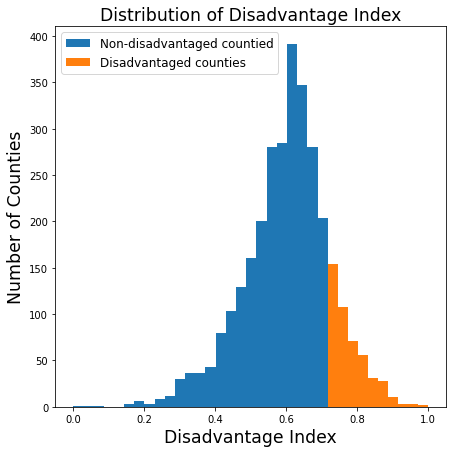

In [6]:
fig, ax = plt.subplots(figsize=(7, 7));
ax.hist(data_no_ak[~data_no_ak.disadvantaged].disadvantage_index, bins=25, label='Non-disadvantaged countied')
ax.hist(data_no_ak[data_no_ak.disadvantaged].disadvantage_index, bins=10, label='Disadvantaged counties')
ax.set_title('Distribution of Disadvantage Index', fontsize='xx-large')
ax.set_ylabel('Number of Counties', fontsize='xx-large')
ax.set_xlabel('Disadvantage Index', fontsize='xx-large')
ax.legend(fontsize='large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_hist.png', clobber=True)
fig.show();

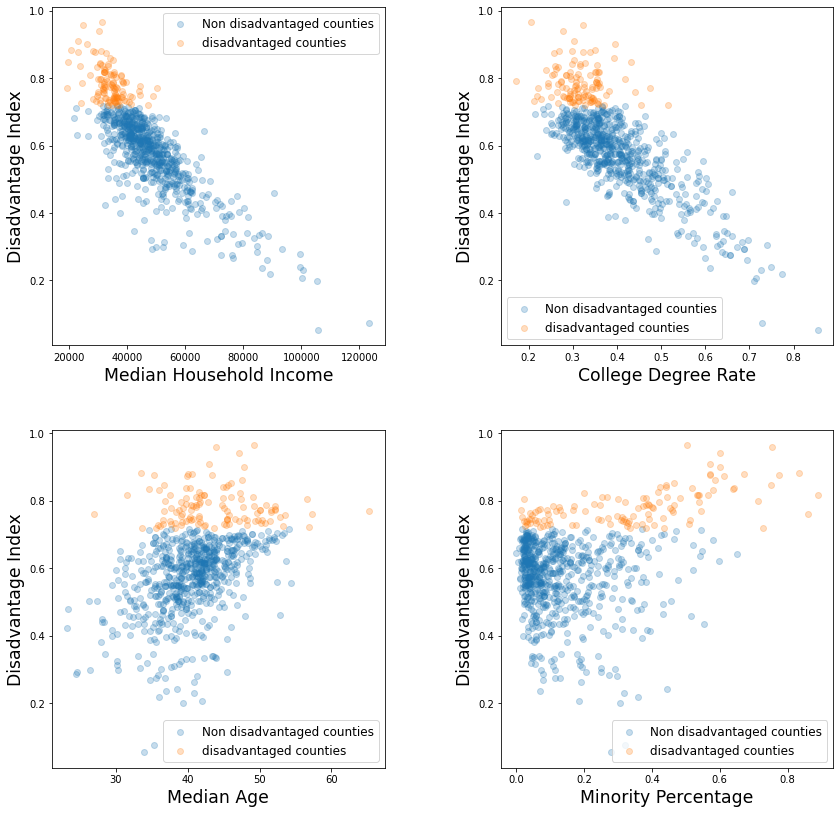

In [7]:
feat_names = ['Median Household Income', 'College Degree Rate', 'Median Age', 'Minority Percentage']
feat_labels = ['Median\nHousehold\nIncome', 'College\nDegree\nRate', 'Median Age', 'Minority\nPercentage']

r, c = 2, 2
fig, ax = plt.subplots(r, c, figsize=(7*c, 7*r))
for i in range(np.prod(ax.shape)):

    # Get index of counties in the bottom 25th percentile
    idx = data_no_ak.disadvantaged
    step = 4
    alpha = 0.25

    # Plot the counties, colored by their percentile
    ax[i // c][i % c].scatter(feat.values[~idx, i][::step], data_no_ak['disadvantage_index'][~idx][::step], alpha=alpha, label='Non disadvantaged counties')
    ax[i // c][i % c].scatter(feat.values[idx, i][::step], data_no_ak['disadvantage_index'][idx][::step], alpha=alpha, label='disadvantaged counties')

    ax[i // c][i % c].set_ylabel('Disadvantage Index', fontsize='xx-large')
    ax[i // c][i % c].set_xlabel(feat_names[i], fontsize='xx-large')
    ax[i // c][i % c].legend(fontsize='large')

fig.subplots_adjust(hspace=0.25, wspace=0.35)
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_correlations.png', clobber=True)
fig.show();

## z-tests

In [0]:
def make_bins(xcol, ycol, n_bins=4):
    bins, means, stds, labels = [], [], [], []

    for i in range(n_bins):
        # Get values in the i-th bin
        bot = i / n_bins
        top = (i + 1) / n_bins
        labels.append('{0:.0%} - {1:.0%}'.format(bot, top))

        idx = (data_no_ak[xcol] > data_no_ak[xcol].quantile(bot)) & (data_no_ak[xcol] < data_no_ak[xcol].quantile(top))

        # Get bin data
        bins.append(data_no_ak[idx][ycol].values)
        means.append(np.mean(bins[i]))
        stds.append(np.std(bins[i]))

    return np.array(bins), means, stds, labels

def plot_split(xcol, ycol='turnout', n_bins=4, title=None):
    
    bins, means, stds, labels = make_bins(xcol, ycol, n_bins)

    # Plot the performance
    fig, ax = plt.subplots(figsize=(2*n_bins, 5))

    # Make the plot
    ax.bar(np.arange(len(means)), means, edgecolor='white')
    ax.errorbar(np.arange(len(means)), means, yerr=stds, fmt=',k', capsize=10)
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels, fontsize='large')
    ax.set_xlabel('Percentile Bins', fontsize='x-large')

    if ycol == 'turnout':
        ax.set_ylabel('Turnout Rate', fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Turnout Rate by {0}'.format(title), fontsize='xx-large')
    elif ycol =='VoterIDLaw':
        ax.set_ylabel('Average Voter ID Law', fontsize='x-large')
        ax.set_title('Voter ID Law Strictness by {0}'.format(title), fontsize='xx-large')

    return fig

def print_ztest(sample1, sample2, target='turnout rate', alpha=0.05):
    dis_std = np.std(dis)
    non_dis_std = np.std(non_dis)

    z_statistic, pval = ztest(sample1,sample2)

    print('Null hypothesis: The two samlpes have the \033[1msame mean', target)
    print("\n\033[0mdisadvantaged mean value: {0:.4f}".format(np.mean(sample1)))
    print("non-disadvantaged mean value: {0:.4f}".format(np.mean(sample2)))

    print("\ndisadvantaged std value: {0:.4f}".format(np.std(sample1)))
    print("non-disadvantaged std value: {0:.4f}".format(np.std(sample2)))

    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, pval))
    if pval < alpha:
        print("we reject null hypothesis")
    else:
        print("we accept null hypothesis")
    print('\033[0m\n\n')

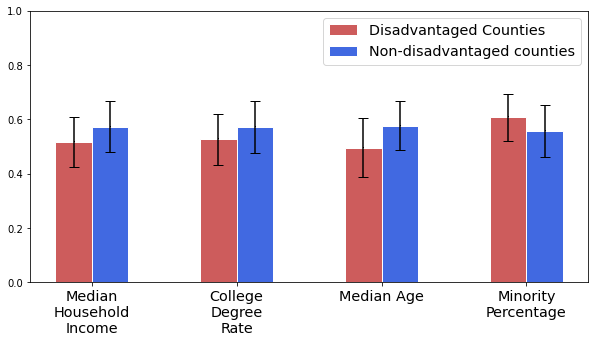

In [9]:
dis_means, non_dis_means = [], []
dis_stds, non_dis_stds = [], []
pvals = []

for c in cols:
    idx = data_no_ak[c] < data_no_ak[c].quantile(0.15)

    # Split the data into disadvantaged and non-disadvantaged
    dis = data_no_ak[idx].turnout.values
    non_dis = data_no_ak[~idx].turnout.values

    # Find the mean of each group
    dis_mean = np.mean(dis)
    dis_means.append(dis_mean)
    non_dis_mean = np.mean(non_dis)
    non_dis_means.append(non_dis_mean)

    # Fint the standard deviation of each group
    dis_std = np.std(dis)
    dis_stds.append(dis_std)
    non_dis_std = np.std(non_dis)
    non_dis_stds.append(non_dis_std)

    # Conduct a z-test on the two groups
    z_statistic, pval = ztest(dis,non_dis)
    pvals.append(pval)

# Set position of bar on X axis
barWidth = 0.25
x1 = np.arange(len(dis_means))
x2 = [x + barWidth for x in x1]

# Plot the performance
fig, ax = plt.subplots(figsize=(10, 5))

# Make the plot
ax.bar(x1, dis_means, color='indianred', width=barWidth, edgecolor='white', label='Disadvantaged Counties')
ax.errorbar(x1, dis_means, yerr=dis_stds, fmt=',k', capsize=5)
ax.bar(x2, non_dis_means, color='royalblue', width=barWidth, edgecolor='white', label='Non-disadvantaged counties')
ax.errorbar(x2, non_dis_means, yerr=non_dis_stds, fmt=',k', capsize=5)
ax.set_xticks((x1 + x2)/2)
ax.set_xticklabels(feat_labels, fontsize='x-large', rotation=0)
ax.set_ylim(0, 1)
ax.set_title('', fontsize='x-large')
ax.legend(fontsize='x-large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantaged_conditional_turnouts.png', clobber=True)
fig.show();

In [10]:
print_ztest(dis, non_dis)

Null hypothesis: The two samlpes have the same mean turnout rate

disadvantaged mean value: 0.6071
non-disadvantaged mean value: 0.5573

disadvantaged std value: 0.0850
non-disadvantaged std value: 0.0969

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis





## Conditional turnout rates and ANOVA

In [0]:
def print_anova(xcol, ycol='turnout', n_bins=4, target='turnout rate', alpha=0.05):
    bins, means, stds, labels = make_bins('MedianHous', 'turnout')
    F, p = f_oneway(*bins)

    print('Null hypothesis: The samlpes have the \033[1msame mean', target, '\033[0m')
    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, pval))
    if p < alpha:
        print("we reject null hypothesis")
    else:
        print("we accept null hypothesis")
    print('\033[0m')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis



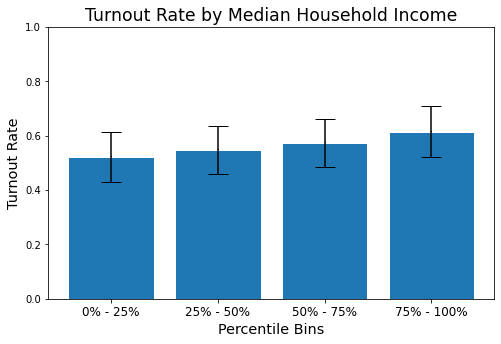

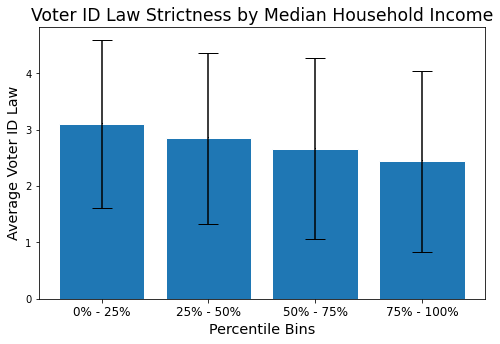

In [12]:
fig = plot_split('MedianHous', 'turnout', 4, 'Median Household Income');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianhous_conditional_turnouts.png', clobber=True)

fig = plot_split('MedianHous', 'VoterIDLaw', 4, 'Median Household Income');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianhous_conditional_idlaw.png', clobber=True)

print_anova('MedianHous', 'turnout', n_bins=4, target='Median Household Income')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis



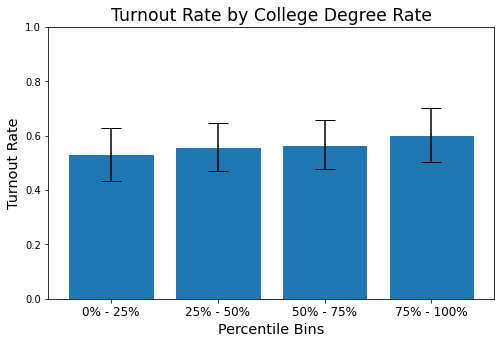

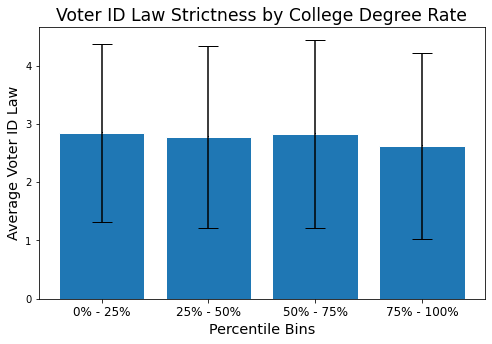

In [13]:
fig = plot_split('CollegeDeg', 'turnout', 4, 'College Degree Rate');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/collegedeg_conditional_turnouts.png', clobber=True)

fig = plot_split('CollegeDeg', 'VoterIDLaw', 4, 'College Degree Rate');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/collegedeg_conditional_idlaw.png', clobber=True)

print_anova('CollegeDeg', 'turnout', n_bins=4, target='Median Household Income')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis



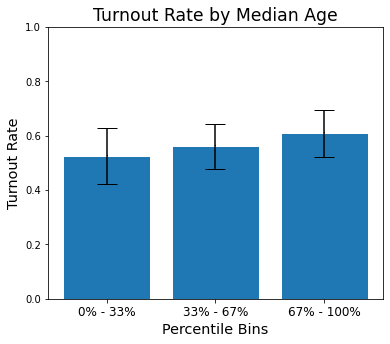

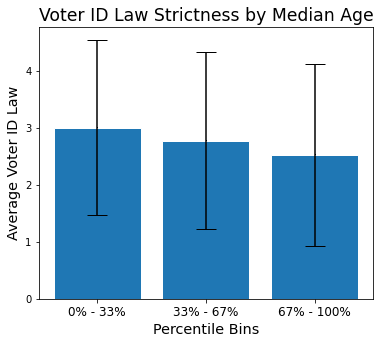

In [14]:
fig = plot_split('MedianAge', 'turnout', 3, 'Median Age');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianage_conditional_turnouts.png', clobber=True)

fig = plot_split('MedianAge', 'VoterIDLaw', 3, 'Median Age');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianage_conditional_idlaw.png', clobber=True)

print_anova('MedianAge', 'turnout', n_bins=3, target='Median Household Income')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis



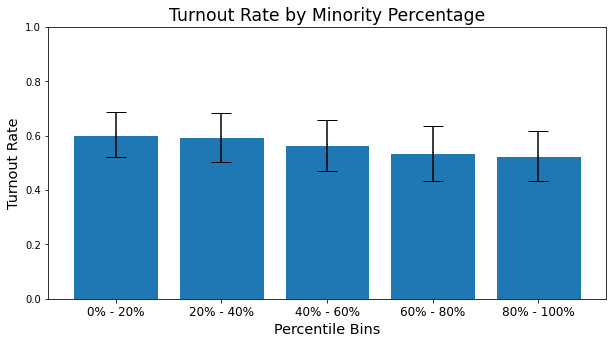

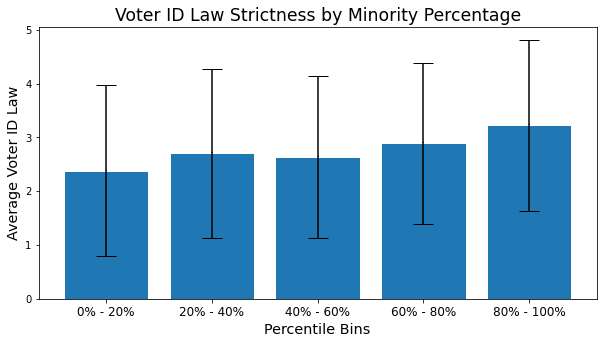

In [15]:
fig = plot_split('not_white', 'turnout', 5, 'Minority Percentage');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/minority_conditional_turnouts.png', clobber=True)

fig = plot_split('not_white', 'VoterIDLaw', 5, 'Minority Percentage');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/minority_conditional_idlaw.png', clobber=True)

print_anova('not_white', 'turnout', n_bins=5, target='Median Household Income')

# Machine Learning Analysis

## Plotting functions

In [0]:
def geoplot_categorical(gdf, col, title="", legend_kwds={'loc':'lower left', 'bbox_to_anchor':(0, 0), 'fontsize':'small'}, show_legend=True):
    """This function plots a categorical variable in a geopandas dataframe with 
    an appropriately sized colorbar adjacent to it.

    Arguments
    ---------------------------------------------------------------------------
    gdf: this is the geopandas dataframe
    col: this ithe column to be plotted
    title: this is the title that is to be given to the plot
    legend_kwds: these are matplotlib legend keywords to describe the legend
        -'loc'
        -'bbox_to_anchor'
        -'fontsize'
    """
    # Make figure, axis, and plot it
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(col, ax=ax, categorical=True, legend=True, cmap='viridis', legend_kwds=legend_kwds);

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Convert labels to integers if possible
    for lbl in ax.get_legend().get_texts():
        label_text = lbl.get_text()
        try:
            lbl.set_text(int(float(label_text)))
        except:
            passz
    if not show_legend:
        ax.get_legend().remove()

    # Label
    ax.set_title(title, fontsize='xx-large')
    fig.tight_layout()
    fig.show();

    return fig, ax

## Data Preparation

In [0]:
feat = data_no_ak.drop(columns=['county_fip', 'turnout', 'county_nam', 'state_abbr', 'VEP', 'STATEFP', 'ElectoralV', 'VoterIDL_1', 'geometry', 'disadvantage_index', 'disadvantaged'])
feat_st = (feat - feat.mean()) / feat.std()

target = data_no_ak.turnout
target_st = (target - target.mean()) / target.std()

X_train, X_test, y_train, y_test = train_test_split(feat_st, target, test_size=0.25, random_state=667)

In [18]:
# Get the voting-eligible persons in each county and state for weighting
vep = np.array(data_no_ak.VEP).reshape(-1, 1)
state_vep = data_no_ak[['state_abbr', 'VEP']].groupby('state_abbr').mean().values

# Weight the features by VEP
feat_wt = np.multiply(vep, feat)

# Group counties by state
feat_wt['state'] = data_no_ak.state_abbr

# Standardize by VEP and normalize data
feat_states = feat_wt.groupby('state').mean() / state_vep
feat_states_st = (feat_states - feat_states.mean()) / feat_states.std()

feat_states.head()

,MedianHous,CollegeDeg,34_younger,35_to_59,60_older,MedianAge,not_white,unemployed,VoterIDLaw
state,,,,,,,,,
AL,44500.447866,0.427330,0.295730,0.430763,0.273508,38.431364,0.310882,0.060625,3.0
AR,41878.943767,0.412084,0.298390,0.422407,0.279203,38.031863,0.219146,0.035405,2.0
AZ,50351.539976,0.441120,0.308040,0.413452,0.278509,37.161379,0.214346,0.052951,4.0
CA,63447.423815,0.503290,0.327991,0.438212,0.233796,35.927705,0.382703,0.053449,1.0
CO,61635.303653,0.541660,0.321136,0.442896,0.235968,36.611010,0.157334,0.031028,2.0


## Clustering at the County Level (Desi)

In [0]:
inertias = []
max_clust = 20
for n in range(2, max_clust+1):
    clust = KMeans(n_clusters=n, random_state=667).fit(clust_cnty_st)
    inertias.append(clust.inertia_)

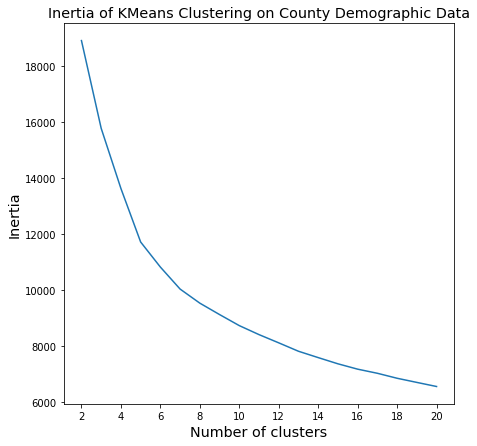

In [37]:
fig , ax = plt.subplots(figsize=(7, 7))
ax.plot(range(2, max_clust+1), inertias)
ax.set_title("Inertia of KMeans Clustering on County Demographic Data", fontsize='x-large')
ax.set_ylabel("Inertia", fontsize='x-large')
ax.set_xlabel("Number of clusters", fontsize='x-large')
ax.set_xticks(range(2, max_clust+1, 2))
ax.set_xticklabels(range(2, max_clust+1, 2));

**Figure:** By observing the decreasing inertia of the clusters, it is not explicitly clear that a certain *k* is optimal. The choice $k=5$ is an appropriate choice. This is also equal to the number of Voter ID Law categories that exist in state legistatures.

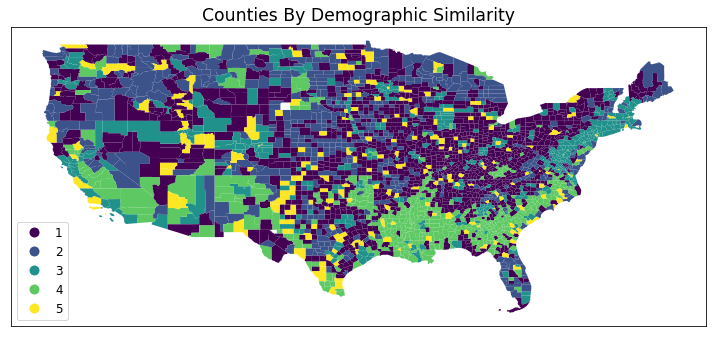

In [19]:
clust_cnty_st = feat_st.drop(columns=['VoterIDLaw'])

clust_1 = KMeans(n_clusters=5, random_state=667).fit(clust_cnty_st)
clust_1.score(clust_cnty_st, target)

data_no_ak['cluster'] = clust_1.predict(clust_cnty_st)
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster.astype(int) + 1

fig, ax = geoplot_categorical(data_mainland, 'cluster', title="Counties By Demographic Similarity", legend_kwds={'loc':'lower left','fontsize':'large'})
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county_demographic_cluster.png');

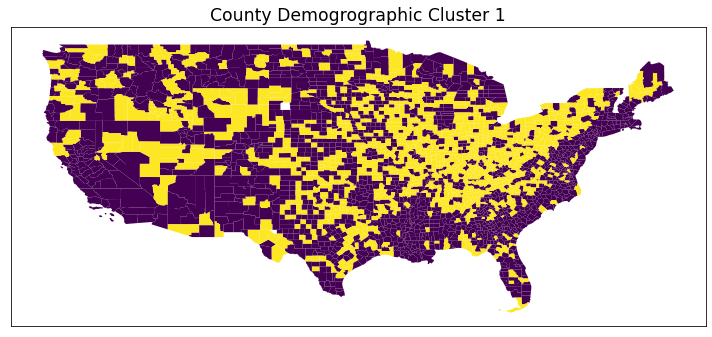

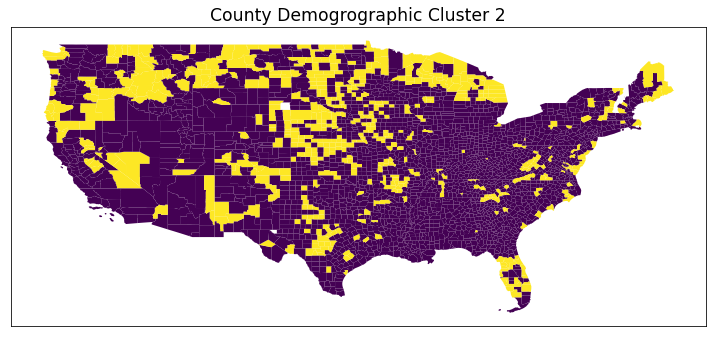

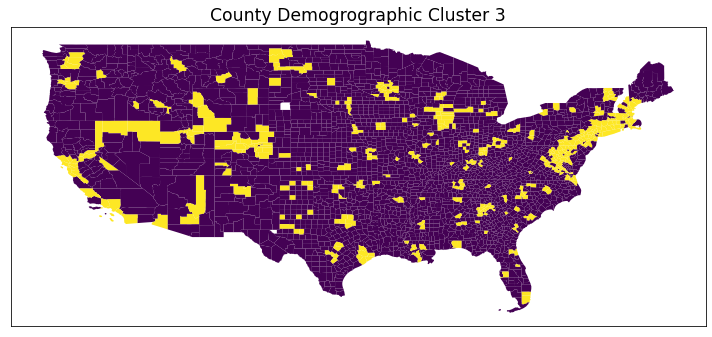

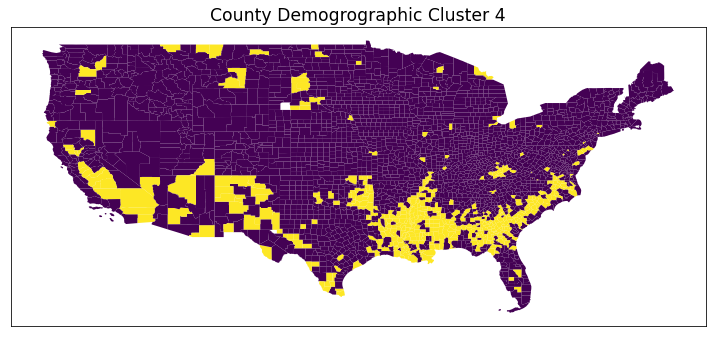

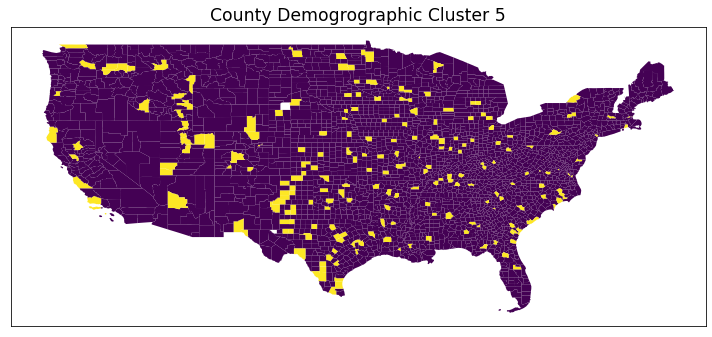

In [20]:
data_no_ak['cluster'] = clust_1.predict(clust_cnty_st)

for i in range(clust_1.n_clusters):
    data_mainland['cluster'] = (data_no_ak[data_no_ak.state_abbr != 'HI'].cluster == i).astype(int) 
    fig, ax = geoplot_categorical(data_mainland, 'cluster', title="County Demogrographic Cluster {0}".format(i+1), show_legend=False)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county_demographic_cluter_{0}.png'.format(i+1))

## Clustering at the State Level (Furkan)


In [21]:
# Use clust_state_st as the data to cluster on
clust_state_st = feat_states_st.drop(columns=['VoterIDLaw'])
clust_state_st

,MedianHous,CollegeDeg,34_younger,35_to_59,60_older,MedianAge,not_white,unemployed
state,,,,,,,,
AL,-1.161490,-0.818598,-0.285999,0.018949,0.327049,0.114650,0.591481,1.523509
AR,-1.445159,-1.036841,-0.188702,-0.554352,0.573943,-0.061207,-0.078536,-0.788974
AZ,-0.528353,-0.621215,0.164201,-1.168801,0.543841,-0.444385,-0.113592,0.819853
CA,0.888730,0.268719,0.893852,0.530099,-1.394498,-0.987437,1.116050,0.865558
CO,0.692644,0.817963,0.643142,0.851484,-1.300369,-0.686653,-0.529999,-1.190372
CT,1.713656,1.628571,-0.970146,1.429799,0.246614,0.983398,-0.027862,0.097241
DC,1.689534,4.016078,4.134497,-3.193492,-2.883258,-1.968051,2.688118,1.609394
DE,0.611911,0.495439,-0.473650,-0.403677,0.816516,0.632662,0.550225,-0.158577
FL,-0.813561,-0.180315,-1.148700,-1.007915,1.998492,1.618130,0.059936,0.520394


## Random Forest (Grace)

In [22]:
# Use X_train, y_train as the training data
# Use X_test, y_test as the test data
X_train
y_train

X_test
y_test

2654    0.529635
2040    0.595399
185     0.554779
1650    0.583219
2114    0.474553
          ...   
147     0.676790
2116    0.529740
1129    0.631424
1683    0.492298
2321    0.660169
Name: turnout, Length: 778, dtype: float64

## Stochastic Gradient Descent (Lan)

In [23]:
# Use X_train, y_train as the training data
# Use X_test, y_test as the test data
X_train
y_train

X_test
y_test

2654    0.529635
2040    0.595399
185     0.554779
1650    0.583219
2114    0.474553
          ...   
147     0.676790
2116    0.529740
1129    0.631424
1683    0.492298
2321    0.660169
Name: turnout, Length: 778, dtype: float64